# Interpolation and Extrapolation

This lecture follows closely [Numerical Recipes](https://numerical.recipes/) 2nd Edition in C and 3rd Edition in C++, Chapter 3 "Interpolation and Extrapolation".

## Introduction

In scientific computing and machine learning, interpolation and extrapolation are fundamental tools for estimating function values at new data points based on known information.
* In machine learning, all standard supervised learning tasks can be viewed as interpolation problems in high-dimensional space. Here, models predict outputs **within the range** of their training data.
* However, when attempting to make predictions outside this range, we face significant challenges in making reliable extrapolations.
  Extrapolation is a particularly challenging task because models typically lack information  beyond their training data.

### Interpolation Methods

Interpolation plays a crucial role in scientific computing and machine learning by estimating function values at new data points based on known information.

* Polynomial interpolation is versatile but can exhibit significant oscillations, particularly at the edges of data (Runge's phenomenon).
* This can be mitigated by using rational functions, which offer more stable estimates and are better suited to handle asymptotic behavior.
* Spline interpolation, especially cubic splines, is valued for its smoothness and continuity up to the second derivative. This makes it effective for applications requiring a smooth fit.

### Challenges with Extrapolation

Extrapolation remains a difficult task, yet physics-informed machine learning (PIML) presents a promising avenue.
By embedding known physical laws, such as ordinary differential equations (ODEs), into models, PIML enables extrapolation that aligns with fundamental constraints. This allows for meaningful extensions of predictions beyond the observed data range.

### Distinguishing Interpolation and Function Approximation

Interpolation and function approximation are related but distinct tasks:

* Interpolation estimates values at specified points within a given dataset.
* In contrast, function approximation creates a simplified function to replace a more complex one.
  This approach can be used to sample additional points as needed.
* (See [Numerical Recipes](https://numerical.recipes/) Chapter 5 for function approximation.)

### Limitations of Interpolation

Even the most sophisticated interpolation schemes can fail when faced with pathological functions.
For instance, consider a function that behaves smoothly except for a slight singularity at a certain point:
\begin{align}
f(x) = 3x^2 + \frac{1}{\pi^4}\ln\left[(\pi - x)^2\right] + 1
\end{align}

Interpolation based on values close to but not precisely at that singularity will likely produce an inaccurate result.

In [1]:
import numpy as np

def f(x):
    return 3 * x**2 + np.log((np.pi - x)**2) / np.pi**4 + 1

x1 = np.linspace(3.13, 3.16, 3+1)
x2 = np.linspace(3.13, 3.16, 30+1)
x3 = np.linspace(3.13, 3.16, 300+1)
x4 = np.linspace(3.13, 3.16, 3000+1)

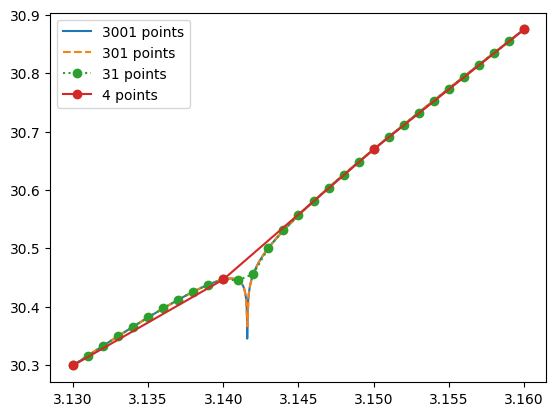

In [2]:
from matplotlib import pyplot as plt

plt.plot(x4, f(x4),       label='3001 points')
plt.plot(x3, f(x3), '--', label='301 points')
plt.plot(x2, f(x2), 'o:', label='31 points')
plt.plot(x1, f(x1), 'o-', label='4 points')
plt.legend()

These cases highlight the importance of having some error estimates in interpolation routines.

## Preliminaries: Searching an Ordered Table

In many interpolation tasks, especially with irregularly sampled data, the process begins with a critical first step: identifying the nearest points surrounding the target interpolation value.

Unlike regularly spaced data on a uniform grid, where adjacent points are easy to locate by simple indexing, randomly sampled or unevenly spaced data requires additional steps to find nearby values.
This searching step can be as computationally intensive as the interpolation itself, so efficient search methods are essential to maintain overall performance.

In Numerical Recipes, two primary methods are presented for this purpose: bisection and hunting.
Each is suited to different scenarios, depending on whether interpolation points tend to be close to one another or scattered randomly.

### Linear Search

As a reference, we will implement a linear search:

In [3]:
def linear(xs, target):
    for l in range(len(xs)): # purposely use for-loop to avoid C optimization in numpy
        if xs[l] >= target:
            return l-1

In [4]:
import numpy as np

for _ in range(10):
    xs = np.sort(np.random.uniform(0, 100, 10))
    v  = np.random.uniform(min(xs), max(xs))
    i  = linear(xs, v)
    print(f'{xs[i]} <= {v} < {xs[i+1]}')

64.58491974808516 <= 64.89769658310183 < 65.44320250814492
38.911191465356175 <= 44.95918474427816 < 46.43657614212642
27.69119540362974 <= 47.248797998505054 < 61.98703083683682
46.983588330588574 <= 54.67257589394714 < 68.35345543379307
5.3923536080885075 <= 13.18980497152959 < 15.058906891143186
65.98295709111551 <= 73.71371375910613 < 75.78709789741922
61.80042323197852 <= 68.33175210523989 < 85.6613172618476
3.0568379618039154 <= 10.183026842733618 < 11.999833928467252
23.446800864020357 <= 27.92154783247216 < 50.29602092889039
4.584795246610196 <= 7.495175910963166 < 9.367992344988686


### Bisection Search

Bisection search is a reliable method that works by dividing the search interval in half with each step until the target value's position is found.
Given a sorted array of $N$ data points, this method requires approximately $\log_2(N)$ steps to locate the closest point, making it efficient even for large datasets.
Bisection is particularly useful when interpolation requests are uncorrelated—meaning there is no pattern in the sequence of target points that could be exploited for faster searching.

In [5]:
def bisection(xs, target):
    l, h = 0, len(xs) - 1
    while h - l > 1:
        m = (h + l) // 2
        if target >= xs[m]:
            l = m
        else:
            h = m
    return l # returns index of the closest value less than or equal to target

The above function efficiently narrows down the interval to locate the index of the nearest value.

We can perform some tests:

In [6]:
for _ in range(10):
    xs = np.sort(np.random.uniform(0, 100, 10))
    v  = np.random.uniform(min(xs), max(xs))
    i  = bisection(xs, v)
    print(f'{xs[i]} <= {v} < {xs[i+1]}')

41.49333238547749 <= 44.87843872930118 < 47.73301106944642
52.6267120872284 <= 55.269316940019564 < 57.1175275220558
72.58347889616996 <= 76.17661169439742 < 80.21959712533337
60.57435382789639 <= 61.63886074461625 < 62.102159674288714
52.85194326905535 <= 62.68075507507969 < 66.55178972028656
8.705761852974636 <= 34.748893231197115 < 36.235595460514915
77.81530224988268 <= 78.78173599894484 < 92.23042979218411
7.250108707446223 <= 7.912262672163501 < 18.983397875546537
70.56492545946266 <= 72.08366904078599 < 79.86592395167526
66.95665573870102 <= 74.00287120158814 < 85.75489912892861


### Hunting Method

For cases where interpolation points are close together in sequence---common in applications with gradually changing target values---the hunting method offers faster performance than bisection from scratch.
Hunting takes advantage of the idea that, if the previous interpolation point is nearby, the search can start close to the last found position and "hunt" outward in expanding steps to bracket the target value.
Once the bracket is located, the search is refined using a quick bisection.

The hunting method is beneficial for correlated data requests, where successive target values are close, as it can skip large portions of the data and converge faster than starting from scratch each time.

In [7]:
def hunt(xs, target, i_last):
    n = len(xs)
    assert 0 <= i_last < n - 1

    # Determine the search direction based on the target value
    if target >= xs[i_last]:
        l, h, step = i_last, min(n-1, i_last+1), 1
        while h < n - 1 and target > xs[h]:
            l, h = h, min(n-1, h+step)
            step *= 2
    else:
        l, h, step = max(0, i_last-1), i_last, 1
        while l > 0 and target < xs[l]:
            l, h = max(0, l-step), l
            step *= 2

    # Refine with bisection within the bracketed range
    return bisection(xs[l:h+1], target) + l

In [8]:
i = 5
for _ in range(10):
    xs = np.sort(np.random.uniform(0, 100, 10))
    v  = np.random.uniform(min(xs), max(xs))
    i  = hunt(xs, v, i)
    print(f'{xs[i]} <= {v} < {xs[i+1]}')

43.77654996977608 <= 50.828312177329764 < 68.5370681313713
38.70972056706887 <= 56.564400737146805 < 57.89129609327457
39.06646981538312 <= 45.10930214626163 < 49.26699300067491
40.63531341666151 <= 45.17660930472748 < 61.64974442616329
12.173597226023581 <= 44.28474146684132 < 45.60672305235365
67.14990748942947 <= 73.58689343415688 < 78.77463844000519
17.08424618056873 <= 48.32008551734421 < 48.74151491430951
96.07968491504704 <= 99.40626786593646 < 99.7398619981059
9.87150103781681 <= 22.2439110963926 < 42.84259452163525
90.08891059223177 <= 96.14131447456195 < 98.67496437033304


### Linear Interpolation Using the Hunting Method

Once the nearest position is identified, interpolation proceeds with the closest data points.
Here, we implement a simple linear interpolation using the hunting method to locate the starting position, then use it to calculate the interpolated value.

In [9]:
class Interpolator:
    def __init__(self, xs, ys):
        assert len(xs) == len(ys)
        self.xs, self.ys = xs, ys
        self.i_last = len(xs)//2

    def __call__(self, target, search_method='hunt'):
        if search_method == 'hunt':
            i = hunt(self.xs, target, self.i_last)
        elif search_method == 'bisection':
            i = bisection(self.xs, target)
        else:
            i = linear(self.xs, target)
        self.i_last = i  # Update last position for future hunts

        # Linear interpolation using the two nearest points
        x0, x1 = self.xs[i], self.xs[i + 1]
        y0, y1 = self.ys[i], self.ys[i + 1]

        return (y1 - y0) * (target - x0) / (x1 - x0) + y0

In [10]:
def f(x):
    return np.exp(-0.5 * x * x)

Xs = np.sort(np.random.uniform(-5, 5, 20))
Ys = f(Xs)

fi = Interpolator(Xs, Ys)

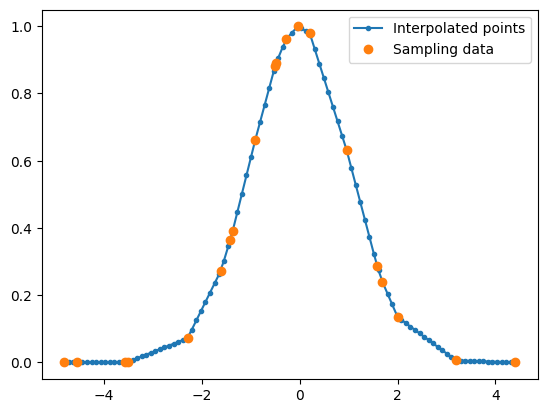

In [11]:
xs = np.linspace(min(Xs), max(Xs), 100)
ys = np.array([fi(x) for x in xs])

plt.plot(xs, ys, '.-', label='Interpolated points')
plt.plot(Xs, Ys, 'o',  label='Sampling data')
plt.legend()

Let's test if our claim in terms of performance works in real life.

In [12]:
Xs = np.sort(np.random.uniform(-5, 5, 1000))
Ys = f(Xs)
fi = Interpolator(Xs, Ys)

xs = np.linspace(min(Xs), max(Xs), 1000)

In [13]:
%timeit ys = np.array([fi(x, search_method='linear') for x in xs])

91.3 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit ys = np.array([fi(x, search_method='bisection') for x in xs])

28.8 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%timeit ys = np.array([fi(x, search_method='hunt') for x in xs])

34.6 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Polynomial Interpolation and Extrapolation

Given $M$ data points $(x_0, y_0), (x_1, y_1), \dots, (x_{M-1}, y_{M_1})$, there exists a unique polynomial of degree $M-1$ that pass through all $M$ points exactly.

### Lagrange's formula

This polynomial is given by Lagrange's classical formula,
\begin{align}
P_{M-1}(x)
&= \frac{(x-x_1)(x-x_2)\dots(x-x_{M-1})}{(x_0-x_1)(x_0-x_2)\dots(x_0-x_{M-1})} y_0 \\
&+ \frac{(x-x_0)(x-x_2)\dots(x-x_{M-1})}{(x_1-x_0)(x_1-x_2)\dots(x_1-x_{M-1})} y_1 + \dots \\
&+ \frac{(x-x_0)(x-x_2)\dots(x-x_{M-2})}{(x_{M-1}-x_0)(x_{M-1}-x_1)\dots(x_{M-1}-x_{M-2})} y_{M-1}
\end{align}
Using summation and product notations, one may rewrite Lagrange's formula as
\begin{align}
P_{M-1}(x)
= \sum_{m=0}^{M-1} \frac{\prod_{n=0,n\ne m}^{M-1}(x-x_n)}{\prod_{n=0,n\ne m}^{M-1}(x_m-x_n)} y_m
\end{align}
Substituting $x = x_{m'}$ for $0 \le m; < M$, it is straightforward to show
\begin{align}
P_{M-1}(x_{m'})
= \sum_{m=0}^{M-1} \delta_{mm'} y_m
\end{align}
and hence $P_{M-1}(x)$ does pass through all data points.

### Neville's Algorithm

Although one may directly implement Lagrange's formula, it does not offer a way to estimate errors.
Instead, we will use Neville's algorithm, which constructs an interpolating polynomial by combining values in a recursive manner.
This approach avoids some of the issues in Lagrange interpolation and is particularly useful for small sets of points where we need an error estimate along with the interpolation result.

Although Numerical Receipts usually give excellent explainations of numerical methods, its section on Neville's Algorithm is a bit confusing.
Here, we try to use some python codes to motivate the algorithm step by step.

1. Note that a polynomial of 0 dgree is simply a constant.
   We use $P_m$ to denote the 0 degree polynomails that approxmation points $(x_m, y_m)$.
   Hence, $P_m = y_m$.
   This is represented by the horizontal bars in the following figure.

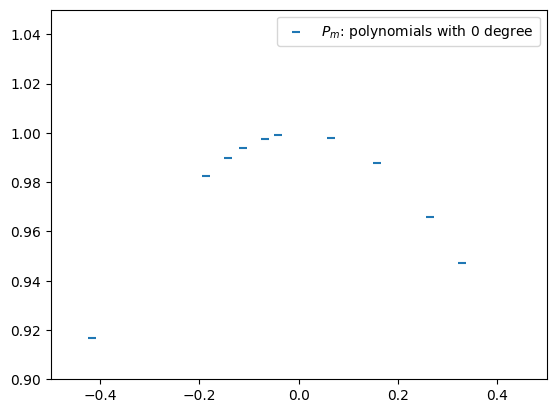

In [16]:
Xs = np.sort(np.random.uniform(-5, 5, 100))
Ys = f(Xs)

plt.scatter(Xs, Ys, marker='_', color='C0', label=r'$P_m$: polynomials with 0 degree')
plt.xlim(-0.5, 0.5)
plt.ylim( 0.9, 1.05)
plt.legend()

2. To improve the accuracy of the approximation, we try to linearly interpolate two nearby points $(x_{m'}, y_{m'})$ and $(x_{m'+1}, y_{m'+1})$.
   For book keeping reason, we will call this polynomial of 1 degree $P_{m',m'+1}$.
   Recall the previous definition $P_{m'} = y_{m'}$ and $P_{m'+1} = y_{m'+1}$,
   we may now use the "two-point form" and write down:
   \begin{align}
   \frac{P_{m',m'+1} - P_{m'}}{x - x_{m'}} &= \frac{P_{m'+1} - P_{m'}}{x_{m'+1} - x_{m'}} \\
   P_{m',m'+1} - P_{m'} &= \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}(P_{m'+1} - P_{m'}) \\
   P_{m',m'+1} &= P_{m'} + \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}(P_{m'+1} - P_{m'}) \\
   P_{m',m'+1} &= \frac{x_{m'+1} - x_{m'}}{x_{m'+1} - x_{m'}}P_{m'} + \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}(P_{m'+1} - P_{m'}) \\
   P_{m',m'+1} &= \left(\frac{x_{m'+1} - x_{m'}}{x_{m'+1} - x_{m'}} - \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}\right)P_{m'} + \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}P_{m'+1} \\
   P_{m',m'+1} &= \frac{x_{m'+1} - x}{x_{m'+1} - x_{m'}}P_{m'} + \frac{x - x_{m'}}{x_{m'+1} - x_{m'}}P_{m'+1} \\
   P_{m',m'+1} &= \frac{(x - x_{m'+1})P_{m'} + (x_{m'} - x)P_{m'+1} }{x_{m'} - x_{m'+1}}
   \end{align}
   This is nothing but a special case of equation (3.2.3) in Numerical Recipes 3rd Edition in C++.

In [17]:
Pmm1s = []
for m in range(len(Xs)-1):
    Pmm1s.append(lambda x: ((x - Xs[m+1]) * Ys[m] + (Xs[m] - x) * Ys[m+1]) / (Xs[m] - Xs[m+1]))

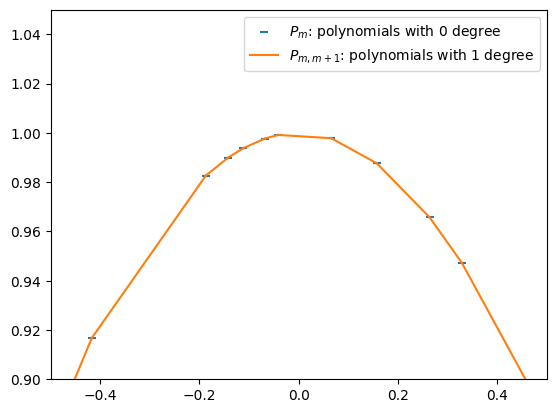

In [18]:
plt.scatter(Xs, Ys, marker='_', color='C0', label=r'$P_m$: polynomials with 0 degree')

label = r'$P_{m,m+1}$: polynomials with 1 degree'
for m, Pmm1 in enumerate(Pmm1s):
    xs = np.linspace(Xs[m], Xs[m+1], 100)
    ys = Pmm1(xs)
    plt.plot(xs, ys, color='C1', label=label)
    label = None

plt.xlim(-0.5, 0.5)
plt.ylim( 0.9, 1.05)
plt.legend()

3. By the same token, to improve the accuracy of the approximation, we linearly interpolate $P_{m'',m''+1}$ and $P_{m''+1,m''+2}$.
   We will call this polynomial of 2 degrees $P_{m'',m''+1,m''+2}$:
   \begin{align}
   P_{m'',m''+1,m''+2} &= \frac{(x - x_{m''+2})P_{m'',m''+1} + (x_{m''} - x)P_{m''+1,m''+2} }{x_{m'} - x_{m'+2}}.
   \end{align}

In [19]:
Pmm1m2s = []
for m in range(len(Xs)-2):
    Pmm1  = lambda x: ((x - Xs[m+1]) * Ys[m  ] + (Xs[m  ] - x) * Ys[m+1]) / (Xs[m  ] - Xs[m+1])
    Pm1m2 = lambda x: ((x - Xs[m+2]) * Ys[m+1] + (Xs[m+1] - x) * Ys[m+2]) / (Xs[m+1] - Xs[m+2])
    Pmm1m2s.append(
        lambda x: ((x - Xs[m+2]) * Pmm1(x) + (Xs[m] - x) * Pm1m2(x)) / (Xs[m] - Xs[m+2])
    )

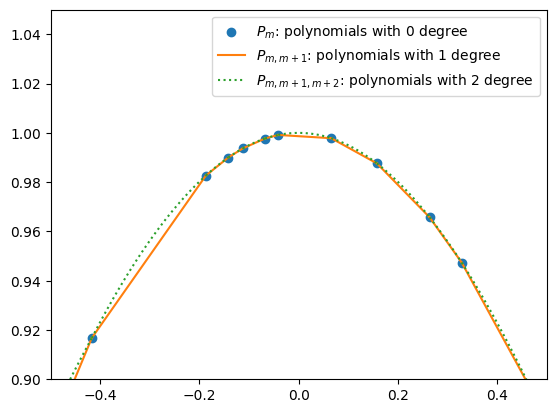

In [20]:
plt.scatter(Xs, Ys, marker='o', color='C0', label=r'$P_m$: polynomials with 0 degree')

label = r'$P_{m,m+1}$: polynomials with 1 degree'
for m, Pmm1 in enumerate(Pmm1s[:-1]):
    xs = np.linspace(Xs[m], Xs[m+1], 100)
    ys = Pmm1(xs)
    plt.plot(xs, ys, color='C1', label=label)
    label = None

label = r'$P_{m,m+1,m+2}$: polynomials with 2 degree'
for m, Pmm1m2 in enumerate(Pmm1m2s):
    xs = np.linspace(Xs[m], Xs[m+1], 100)
    ys = Pmm1m2(xs)
    plt.plot(xs, ys, ':', color='C2', label=label)
    label = None

plt.xlim(-0.5, 0.5)
plt.ylim( 0.9, 1.05)
plt.legend()

4. Doing this recursively, we obtain Neville's algorithm, equation (3.2.3) in Numerical Recipes:
   \begin{align}
   P_{m,m+1,\dots,m+n} &= \frac{(x - x_{m+n})P_{m,m+1,\dots,m+n-1} + (x_{m} - x)P_{m+1,m+2,\dots,m+n} }{x_{m} - x_{m+n}}.
   \end{align}

5. Recalling the **catastrophic cancellation** discussed in [](data.md), given that $P_{m,m+1,\dots,m+n} - P_{m,m+1,\dots,m+n-1}$ has the meaning of "small correction", it is better to keep track of this small quantities instead of $P_{m,m+1,\dots,m+n}$ themselves.
   Following Numerical Recipes, we define
   \begin{align}
   C_{n,m} &\equiv P_{m,m+1,\dots,m+n} - P_{m,m+1,\dots,m+n-1} \\
   D_{n,m} &\equiv P_{m,m+1,\dots,m+n} - P_{m+1,m+2,\dots,m+n}
   \end{align}
   Neville's algorithm can now be rewritten as
   \begin{align}
   D_{n+1,m} &= \frac{x_{m+n+1}-x}{x_m - x_{m+n+1}}(C_{n,m+1} - D_{n,m}) \\
   C_{n+1,m} &= \frac{x_{n}-x}{x_m - x_{m+n+1}}(C_{n,m+1} - D_{n,m})
   \end{align}
   From this expression, it is now clear that the $C$'s and $D$'s are the corrections that make the interpolation one order higher.

6. The final polynomial $P_{0,1,\dots,M-1}$ is equal to the sum of *any* $y_i$ plus a set of $C$'s and/or $D$'s that form a path through the family tree of $P_{m,m+1,\dots,m+n}$.

In [21]:
class PolynomialInterpolator:
    def __init__(self, xs, ys, n=None):
        if n is None:
            n = len(xs)

        assert len(xs) == len(ys)
        assert len(xs) >= n

        self.xs, self.ys, self.n = xs, ys, n

    def __call__(self, target, search_method='hunt'):

        C = np.copy(self.ys)
        D = np.copy(self.ys)

        i = np.argmin(abs(self.xs - target))
        y = self.ys[i]
        i-= 1

        for n in range(1,self.n):
            ho  = self.xs[:-n] - target
            hp  = self.xs[+n:] - target
            w   = C[1:self.n-n+1] - D[:-n]
            den = ho - hp
            if any(den == 0):
                raise Exception("two input xs are (to within roundoﬀ) identical.")
            else:
                f = w / den
            D[:-n] = hp * f
            C[:-n] = ho * f

            if 2*(i+1) < (self.n-n):
                self.dy = C[i+1]
            else:
                self.dy = D[i]
                i -= 1

            y += self.dy

        return y

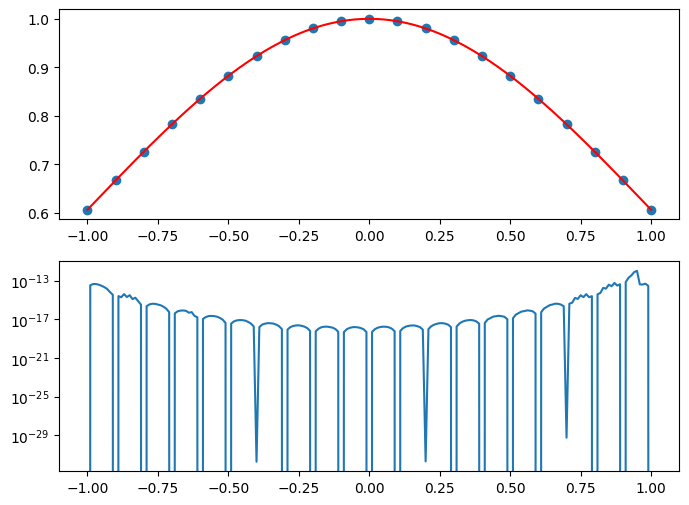

In [22]:
Xs = np.linspace(-1,1,21)
#Xs = np.linspace(-5,5,21)
#Xs = -5 * np.cos(np.linspace(0, np.pi, 21))
Ys = np.exp(-0.5 * Xs*Xs)
P = PolynomialInterpolator(Xs, Ys)

xs = np.linspace(-1,1,201)
#xs = np.linspace(-5,5,201)
ys = []
es = []
for x in xs:
    ys.append(P(x))
    es.append(P.dy)
ys = np.array(ys)
es = np.array(es)

fig, axes = plt.subplots(2,1,figsize=(8,6))
axes[0].scatter(Xs, Ys)
axes[0].plot(xs, ys, '-', color='r')
axes[1].semilogy(xs, abs(es))

### Discussion

* How does the error converge if we increase (or decrease) the number of sampling points?
* What will happen if we increase the size of the domain?  (This is called Runge phenomenon.)
* What will happen if we try to extrapolate?

## Summary

In this lecture, we studied interpolation techniques, focusing on polynomial interpolation.
We derive and implemented Neville's Algorithm, a recursive method that constructs an interpolating polynomial while also providing an internal error estimate.
This technique offers insight into the stability of interpolation at specific points, making it particularly useful for small datasets.

However, polynomial interpolation is not always the best choice, especially for large datasets or unevenly spaced data.
Alternative techniques such as cubic splines, rational function interpolation, and multidimensional interpolation provide more robust and flexible approaches.

For further study, we recommend exploring:

* Cubic Spline Interpolation: A method that ensures smoothness across intervals, mitigating oscillatory behavior.

* Rational Function Interpolation: A technique that models asymptotic behavior effectively, reducing instability.

* Interpolating Polynomial Coefficients: A computationally efficient way to determine polynomial coefficients directly.

* Multidimensional Interpolation: Methods for interpolating data in multiple dimensions, applicable to spatial data analysis.

* Laplace Interpolation: A specialized approach for interpolating harmonic functions using Laplace’s equation.

Understanding these advanced methods can help address the challenges posed by polynomial interpolation and extend its practical applications to more complex interpolation problems.